# Task 3 – Exploratory Analysis (Python)

## 1. Data Understanding & Cleaning
- Load the datasets
- Handle missing values or outliers if necessary

In [2]:
#301360037
#maaz bobat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
# load the data into a pandas dataframe
df_events = pd.read_csv("../data/events.csv")
df_devices = pd.read_csv("../data/devices.csv")
df_users = pd.read_csv("../data/users.csv")

In [3]:
# ---- Explore Users -----
# number of rows and columns.
print(df_users.shape)
# Print first 5 rows to understand the data structure
print(df_users.head(), "\n")
# statistical summary of the dataset
print(df_users.describe(), "\n")
print("Missing values (Users):")
print(df_users.isnull().sum())
# Unique values for categorical columns
print("Unique Regions:  ", df_users["region"].unique())
print("Unique Platforms:", df_users["platform"].unique())


(121, 4)
    user_id signup_date         region  platform
0  739b720a  2023-04-21  United States       iOS
1  0aa3325c  2023-06-12             US       iOS
2  b5a2048e  2023-08-20             KR       Web
3  a4a70166  2023-05-26            can  3rdParty
4  2386e2a0  2023-01-18            USA   Android 

         user_id signup_date         region platform
count        121         121            121      121
unique       120         103              8        4
top     739b720a  2023-04-21  United States      iOS
freq           2           2             18       32 

Missing values (Users):
user_id        0
signup_date    0
region         0
platform       0
dtype: int64
Unique Regions:   ['United States' 'US' 'KR' 'can' 'USA' 'CA' 'JP' 'Canada']
Unique Platforms: ['iOS' 'Web' '3rdParty' 'Android']


In [4]:
# ----Explore Devices----
# number of rows and columns.
print("devices shape:", df_devices.shape)
# Print first 5 rows to understand the data structure
print(df_devices.head(), "\n")
# statistical summary of the dataset
print(df_devices.describe(), "\n")
print("Missing values (Devices):")
print(df_devices.isnull().sum())
# Unique values for categorical columns
print("Unique Networks:         ", df_devices["network"].unique())
print("Unique Device Types:     ", df_devices["device_type"].unique())
print("Unique Firmware Versions:", df_devices["firmware_version"].unique())
print("Unique Locations:        ", df_devices["location"].unique())
print(f"\nDuplicate device_ids: {df_devices.duplicated(subset='device_id').sum()}")

devices shape: (450, 6)
    device_id   user_id network device_type firmware_version location
0  d_f4abcb9e  89a25ef6    tuya         fan            1.0.3   Office
1  d_212b804b  2f555493    tuya  smart_plug            1.0.0      NaN
2  d_32b272b3  f41317b2    tuya      heater         3.5.beta      NaN
3  d_f6fe781d  ee413bc3    tuya         fan         3.5.beta      NaN
4  d_8555efd8  cd6e76a2    tuya  smart_bulb         3.5.beta     Home 

         device_id   user_id network device_type firmware_version location
count          450       425     450         450              450      342
unique         450       119       2           8                4        3
top     d_9f01e3d6  739b720a    tuya  thermostat            2.1.0     Home
freq             1        10     228          70              115      136 

Missing values (Devices):
device_id             0
user_id              25
network               0
device_type           0
firmware_version      0
location            108
dtype: 

In [5]:
# ----- Explore Events -----
print(df_events.shape)
print(df_events.head(), "\n")
print(df_events.describe(), "\n")
print(df_events.isnull().sum())

# Sample one payload per structure to understand what we're working with
print("Unique event_types:", df_events["event_type"].unique())
print("Unique event_values:", df_events["event_value"].unique())

# Inspect two raw payloads to identify the two structures
sample_metadata = df_events[df_events["payload"].str.contains('"metadata"')].iloc[0]
sample_status = df_events[df_events["payload"].str.contains('"status"')].iloc[0]

print("\n── Payload A ──")
print(json.dumps(json.loads(sample_metadata["payload"]), indent=2))
print("\n── Payload B ──")
print(json.dumps(json.loads(sample_status["payload"]), indent=2))

# Cross reference to confirm which structure belongs to which network
device_a = df_devices[df_devices["device_id"] == sample_metadata["device_id"]][
    ["device_id", "network"]
]
device_b = df_devices[df_devices["device_id"] == sample_status["device_id"]][
    ["device_id", "network"]
]
print("\nPayload A → network:", device_a["network"].values[0])
print("Payload B → network:", device_b["network"].values[0])

print(f"\nDuplicate event_ids:      {df_events.duplicated(subset='event_id').sum()}")
print(
    f"Duplicate timestamps:     {df_events.duplicated(subset='event_ts').sum()} — may indicate batch reporting or duplicate submissions"
)
print("\nNOTE: 'event_value' column contains only 'see_payload' for all rows.")
print("All meaningful values are embedded in the 'payload' JSON column.")
ayla_codes = {}
tuya_codes = {}
parse_errors = 0

for raw in df_events["payload"]:
    try:
        data = json.loads(raw)
    except (json.JSONDecodeError, TypeError):
        parse_errors += 1
        continue

    # Ayla structure — collect datapoint property names
    if "metadata" in data and "datapoint" in data:
        prop = data["datapoint"].get("property")
        if prop:
            ayla_codes[prop] = ayla_codes.get(prop, 0) + 1

    # Tuya structure — collect all status codes
    elif "status" in data and isinstance(data["status"], list):
        for item in data["status"]:
            code = item.get("code")
            if code:
                tuya_codes[code] = tuya_codes.get(code, 0) + 1

print(f"Parse errors: {parse_errors}")

print("\n── Ayla Payload Keys (datapoint.property) ──")
for k, v in sorted(ayla_codes.items(), key=lambda x: -x[1]):
    print(f"  {k:<30} {v} occurrences")

print("\n── Tuya Payload Keys (status[].code) ──")
for k, v in sorted(tuya_codes.items(), key=lambda x: -x[1]):
    print(f"  {k:<30} {v} occurrences")

(15000, 6)
  event_id   device_id event_type  event_value                  event_ts  \
0      e_0  d_87cfe321  telemetry  see_payload  2024-01-18T17:45:43.000Z   
1      e_1  d_fddd9d33  telemetry  see_payload  2024-02-04T16:18:19.000Z   
2      e_2  d_c5859fb6  telemetry  see_payload  2024-01-12T10:57:04.000Z   
3      e_3  d_de3f2763  telemetry  see_payload  2024-01-02T08:09:18.000Z   
4      e_4  d_8406c179  telemetry  see_payload  2024-01-23T01:15:16.000Z   

                                             payload  
0  {"metadata": {"oem_model": "door_sensor", "dsn...  
1  {"metadata": {"oem_model": "window_sensor", "d...  
2  {"status": [{"code": "generic_state", "value":...  
3  {"status": [{"code": "switch_led", "value": fa...  
4  {"status": [{"code": "generic_state", "value":...   

       event_id   device_id event_type  event_value                  event_ts  \
count     15000       15000      15000        15000                     15000   
unique    15000         450          1

In [6]:
# ---- Clean Users ----
# only US and Canada have the messy variants. Any region not in region_map will be set to Other
region_map = {
    "United States": "US",
    "USA": "US",
    "US": "US",
    "Canada": "CA",
    "can": "CA",
    "CA": "CA",
    "KR": "KR",
    "JP": "JP",
}
df_users["region"] = df_users["region"].map(region_map).fillna("Other")
# Parse signup_date to datetime
df_users["signup_date"] = pd.to_datetime(df_users["signup_date"])
#count duplicate
dupe_count = df_users.duplicated(subset="user_id", keep="first").sum()
# Drop duplicate user_id
df_users = df_users.drop_duplicates(subset="user_id", keep="first")
print(f"Duplicate user_ids dropped: {dupe_count}")
print(f"Shape: {df_users.shape}")
print(df_users["region"].value_counts().to_string())

Duplicate user_ids dropped: 1
Shape: (120, 4)
region
US    47
CA    45
KR    17
JP    11


In [7]:
# ---Clean Devices ---
df_devices["location"] = df_devices["location"].fillna("Unknown")
df_devices["user_id_missing"] = df_devices["user_id"].isnull()

orphan_events = df_events.merge(
    df_devices[["device_id", "user_id_missing"]], on="device_id", how="left"
)

print(f"Location nulls filled:       {(df_devices['location'] == 'Unknown').sum()}")
print(f"Orphan devices (no user_id): {df_devices['user_id_missing'].sum()}")
print(f"Events from orphan devices:  {orphan_events['user_id_missing'].sum()}")
print(
    f"Devices on beta firmware:    {(df_devices['firmware_version'] == '3.5.beta').sum()}"
)
beta_orphan_overlap = df_devices[
    (df_devices["firmware_version"] == "3.5.beta") & (df_devices["user_id_missing"])
].shape[0]
print(f"Beta firmware + no user_id:  {beta_orphan_overlap} — highest data quality risk devices")
print("Beta firmware (3.5.beta) may produce unreliable telemetry.")


Location nulls filled:       108
Orphan devices (no user_id): 25
Events from orphan devices:  749
Devices on beta firmware:    115
Beta firmware + no user_id:  4 — highest data quality risk devices
Beta firmware (3.5.beta) may produce unreliable telemetry.


In [8]:
# Clean Events (Handle Payload)
def parse_payload(raw):
    try:
        data = json.loads(raw)
    except (json.JSONDecodeError, TypeError):
        return pd.Series(
            {
                "source": "parse_error",
                "extracted_code": None,
                "extracted_value": None,
                "voltage": None,
                "current": None,
                "power": None,
                "temperature_c": None,
            }
        )

    # Ayla structure
    if "metadata" in data and "datapoint" in data:
        prop = data["datapoint"].get("property")
        value = data["datapoint"].get("value")
        return pd.Series(
            {
                "source": "ayla",
                "extracted_code": prop,
                "extracted_value": value,
                "voltage": None,
                "current": None,
                "power": None,
                "temperature_c": value if prop == "local_temperature" else None,
            }
        )

    # Tuya structure — loop all status items to capture multi-value events
    if "status" in data and isinstance(data["status"], list) and data["status"]:
        status_map = {
            item.get("code"): item.get("value")
            for item in data["status"]
            if item.get("code")
        }
        first = data["status"][0]
        return pd.Series(
            {
                "source": "tuya",
                "extracted_code": first.get("code"),
                "extracted_value": first.get("value"),
                "voltage": status_map.get("cur_voltage"),  # raw ÷ 10 = volts
                "current": status_map.get("cur_current"),  # raw ÷ 1000 = amps
                "power": status_map.get("cur_power"),  # raw ÷ 10 = watts
                "temperature_c": status_map.get("local_temperature"),
            }
        )

    return pd.Series(
        {
            "source": "unknown",
            "extracted_code": None,
            "extracted_value": None,
            "voltage": None,
            "current": None,
            "power": None,
            "temperature_c": None,
        }
    )


print("Parsing payload column (15,000 rows)...")
parsed = df_events["payload"].apply(parse_payload)
df_events = pd.concat([df_events, parsed], axis=1)

# Parse timestamp and extract date for daily aggregations
df_events["event_ts"] = pd.to_datetime(df_events["event_ts"], utc=True)
df_events["date"] = df_events["event_ts"].dt.date

# Convert extracted_value to numeric — booleans (True/False) become 1/0
df_events["extracted_value_numeric"] = pd.to_numeric(
    df_events["extracted_value"].apply(lambda x: int(x) if isinstance(x, bool) else x),
    errors="coerce",
)

# Scale raw Tuya electrical values to proper units
df_events["voltage_v"] = df_events["voltage"] / 10
df_events["current_a"] = df_events["current"] / 1000
df_events["power_w"] = df_events["power"] / 10

print("── Events Cleaned ──")
print(f"Shape: {df_events.shape}")
print(f"\nPayload source breakdown:")
print(df_events["source"].value_counts().to_string())
print(f"\nAll unique extracted codes:")
print(df_events["extracted_code"].value_counts().to_string())
print(f"\nDedicated measurement columns:")
print(f"  temperature_c: {df_events['temperature_c'].notna().sum()} readings")
print(f"  voltage_v:     {df_events['voltage_v'].notna().sum()} readings")
print(f"  current_a:     {df_events['current_a'].notna().sum()} readings")
print(f"  power_w:       {df_events['power_w'].notna().sum()} readings")

print(f"\nextracted_value_numeric non-null: {df_events['extracted_value_numeric'].notna().sum()} / {len(df_events)}")
print("Note: String values like 'online', 'open', 'closed' are intentionally NaN — use extracted_value for categorical analysis.")

dup_ts = df_events.duplicated(subset="event_ts").sum()
print(f"Duplicate timestamps in events: {dup_ts} — kept all rows, could be batch reporting from same device tick")

Parsing payload column (15,000 rows)...
── Events Cleaned ──
Shape: (15000, 18)

Payload source breakdown:
source
tuya    8319
ayla    6681

All unique extracted codes:
extracted_code
generic_state        4999
contact_state        3228
local_temperature    2092
switch_led           1890
switch_1             1430
connectivity         1361

Dedicated measurement columns:
  temperature_c: 2092 readings
  voltage_v:     1430 readings
  current_a:     1430 readings
  power_w:       1430 readings

extracted_value_numeric non-null: 8640 / 15000
Note: String values like 'online', 'open', 'closed' are intentionally NaN — use extracted_value for categorical analysis.
Duplicate timestamps in events: 24 — kept all rows, could be batch reporting from same device tick


In [9]:
# ---Verify + Final Summary--
df_check = df_events.merge(
    df_devices[["device_id", "network"]], on="device_id", how="left"
)
print(df_check.groupby(["network", "source"]).size())
print(f"Events with unknown device_id: {df_check['network'].isna().sum()}")

print("\n---- Final Dataset Summary ----")
print(f"Users:   {df_users.shape[0]} rows | Regions: {sorted(df_users['region'].unique())}")
print(f"Devices: {df_devices.shape[0]} rows | Networks: {df_devices['network'].unique().tolist()}")
print(f"Events:  {df_events.shape[0]} rows | Date range: {df_events['date'].min()} → {df_events['date'].max()}")
print("\n---- Data Quality Summary ----")
print(f"  Duplicate user_ids dropped:          1")
print(f"  Region variants normalized:          United States/USA → US, Canada/can → CA")
print(f"  Orphan devices (no user_id):         {df_devices['user_id_missing'].sum()}")
print(f"  Events from orphan devices:          {orphan_events['user_id_missing'].sum()}")
print(f"  Devices on beta firmware (3.5.beta): {(df_devices['firmware_version'] == '3.5.beta').sum()} — telemetry reliability risk")
print(f"  Beta firmware + no user_id:          {beta_orphan_overlap} — highest risk")
print(f"  Location nulls filled as 'Unknown':  {(df_devices['location'] == 'Unknown').sum()}")
print(f"  Duplicate event timestamps:          {df_events.duplicated(subset='event_ts').sum()} — kept, likely batch reporting")
print(f"  event_value column:                  placeholder only ('see_payload') — real values in parsed payload columns")
print(f"  extracted_value_numeric non-null:    {df_events['extracted_value_numeric'].notna().sum()} / {len(df_events)} rows")

network  source
ayla     ayla      6681
tuya     tuya      8319
dtype: int64
Events with unknown device_id: 0

---- Final Dataset Summary ----
Users:   120 rows | Regions: ['CA', 'JP', 'KR', 'US']
Devices: 450 rows | Networks: ['tuya', 'ayla']
Events:  15000 rows | Date range: 2024-01-01 → 2024-02-07

---- Data Quality Summary ----
  Duplicate user_ids dropped:          1
  Region variants normalized:          United States/USA → US, Canada/can → CA
  Orphan devices (no user_id):         25
  Events from orphan devices:          749
  Devices on beta firmware (3.5.beta): 115 — telemetry reliability risk
  Beta firmware + no user_id:          4 — highest risk
  Location nulls filled as 'Unknown':  108
  Duplicate event timestamps:          24 — kept, likely batch reporting
  event_value column:                  placeholder only ('see_payload') — real values in parsed payload columns
  extracted_value_numeric non-null:    8640 / 15000 rows


## 2. Visualizations
Produce at least 3 meaningful charts, such as:
- Event volume over time
- Events per device or per user
- Comparison between Ayla vs Tuya devices
- Highlight any anomalies or interesting patterns

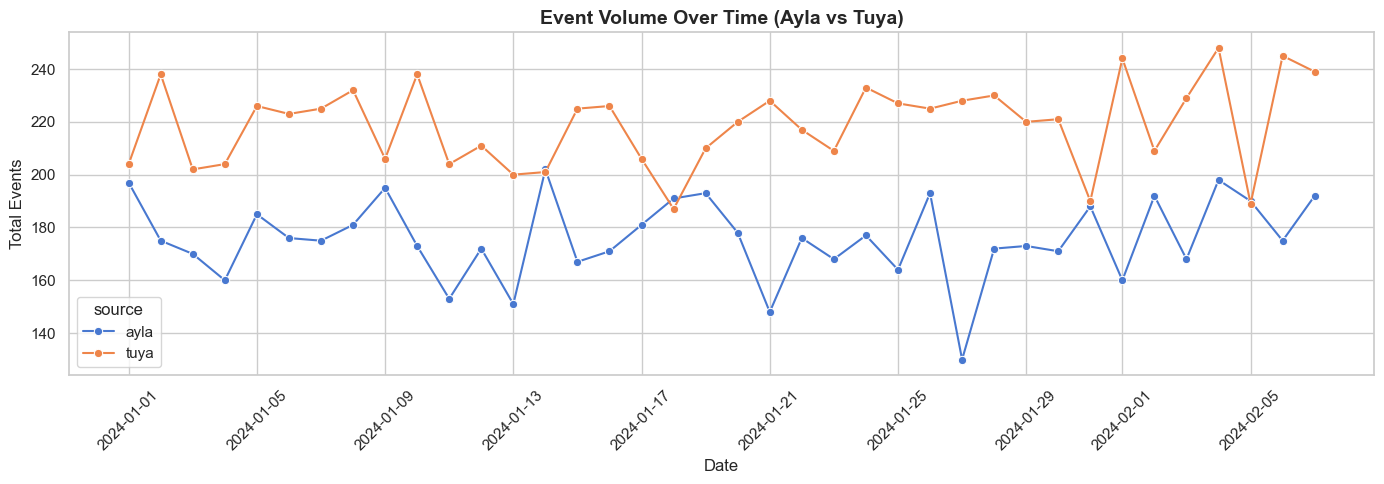

Saved: chart1_event_volume_over_time.png


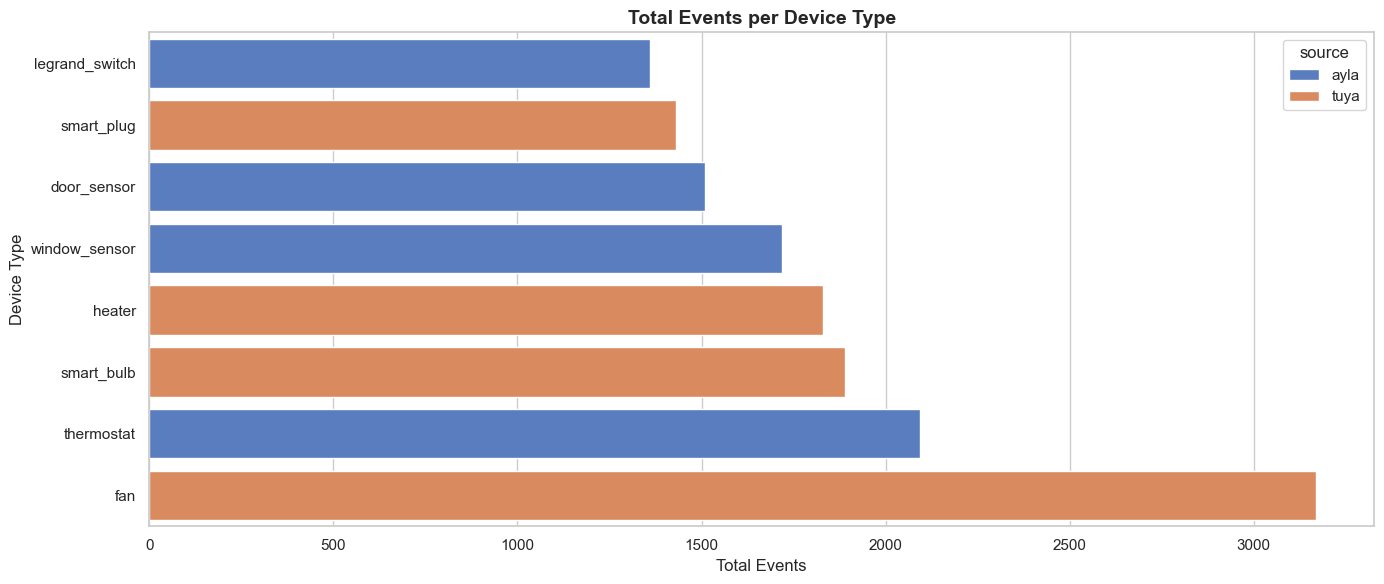

Saved: chart2_events_per_device_type.png


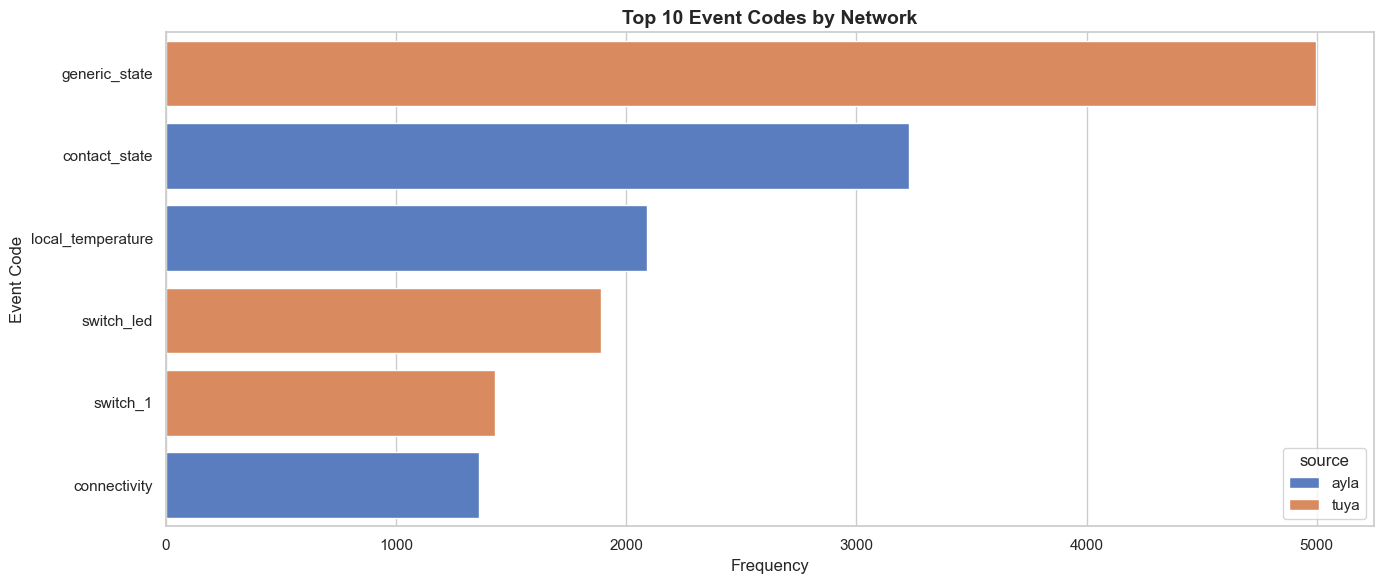

Saved: chart3_event_codes_ayla_vs_tuya.png


In [ ]:
import os

os.makedirs("../charts", exist_ok=True)

# Set visual theme
sns.set_theme(style="whitegrid", palette="muted")



# Chart 1: Event Volume Over Time (Line Chart)
fig, ax = plt.subplots(figsize=(14, 5))

daily_vol = df_events.groupby(["date", "source"]).size().reset_index(name="count")
sns.lineplot(data=daily_vol, x="date", y="count", hue="source", marker="o", ax=ax)

ax.set_title("Event Volume Over Time (Ayla vs Tuya)", fontsize=14, fontweight="bold")
ax.set_ylabel("Total Events")
ax.set_xlabel("Date")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("../charts/chart1_event_volume_over_time.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart1_event_volume_over_time.png")


# Chart 2: Events per Device Type (Horizontal Bar)
fig, ax = plt.subplots(figsize=(14, 6))

device_vol = df_events.merge(
    df_devices[["device_id", "device_type"]], on="device_id", how="left"
)
dev_type_counts = (
    device_vol.groupby(["device_type", "source"]).size().reset_index(name="count")
)

# Sort by total events per device type
order = (
    dev_type_counts.groupby("device_type")["count"]
    .sum()
    .sort_values(ascending=True)
    .index
)

sns.barplot(
    data=dev_type_counts, y="device_type", x="count", hue="source", ax=ax, order=order
)

ax.set_title("Total Events per Device Type", fontsize=14, fontweight="bold")
ax.set_xlabel("Total Events")
ax.set_ylabel("Device Type")

plt.tight_layout()
plt.savefig("../charts/chart2_events_per_device_type.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart2_events_per_device_type.png")



# Chart 3: Ayla vs Tuya Event Code Comparison (Horizontal Grouped Bar)
fig, ax = plt.subplots(figsize=(14, 6))

top_codes = df_events["extracted_code"].value_counts().nlargest(10).index
filtered_codes = df_events[df_events["extracted_code"].isin(top_codes)]

sns.countplot(
    data=filtered_codes, y="extracted_code", hue="source", order=top_codes, ax=ax
)

ax.set_title("Top 10 Event Codes by Network", fontsize=14, fontweight="bold")
ax.set_xlabel("Frequency")
ax.set_ylabel("Event Code")

plt.tight_layout()
plt.savefig(
    "../charts/chart3_event_codes_ayla_vs_tuya.png", dpi=150, bbox_inches="tight"
)
plt.show()
print("Saved: chart3_event_codes_ayla_vs_tuya.png")


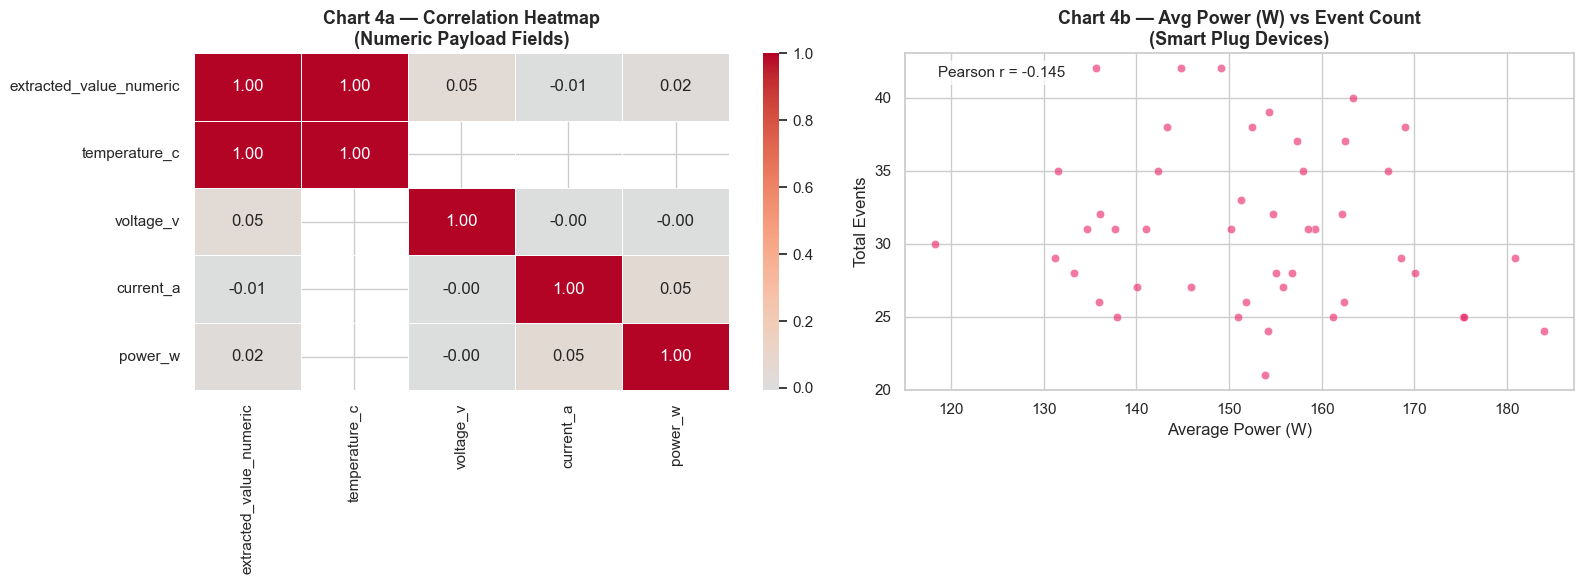

Saved: chart4_correlation.png


In [ ]:

# Chart 4: Correlation Heatmap + Scatter
# ---- Build merged DataFrame ----
df_merged = df_events.merge(
    df_devices[["device_id", "device_type", "network", "user_id", "firmware_version"]],
    on="device_id",
    how="left",
)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---- Chart 4a: Correlation Heatmap ----
numeric_cols = [
    "extracted_value_numeric",
    "temperature_c",
    "voltage_v",
    "current_a",
    "power_w",
]
corr_matrix = df_merged[numeric_cols].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    ax=axes[0],
    center=0,
    linewidths=0.5,
)
axes[0].set_title(
    "Chart 4a — Correlation Heatmap\n(Numeric Payload Fields)",
    fontsize=13,
    fontweight="bold",
)

# ---- Chart 4b: Avg Power vs Avg Daily Events per Device ----
device_corr = (
    df_merged[df_merged["power_w"].notna()]
    .groupby("device_id")
    .agg(avg_daily_events=("event_id", "count"), avg_power=("power_w", "mean"))
    .reset_index()
)
r = device_corr["avg_power"].corr(device_corr["avg_daily_events"])

axes[1].scatter(
    device_corr["avg_power"],
    device_corr["avg_daily_events"],
    alpha=0.6,
    color="#E91E63",
    edgecolors="white",
    linewidth=0.5,
)
axes[1].annotate(
    f"Pearson r = {r:.3f}",
    xy=(0.05, 0.93),
    xycoords="axes fraction",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
)
axes[1].set_title(
    "Chart 4b — Avg Power (W) vs Event Count\n(Smart Plug Devices)",
    fontsize=13,
    fontweight="bold",
)
axes[1].set_xlabel("Average Power (W)")
axes[1].set_ylabel("Total Events")

plt.tight_layout()
plt.savefig("../charts/chart4_correlation.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart4_correlation.png")

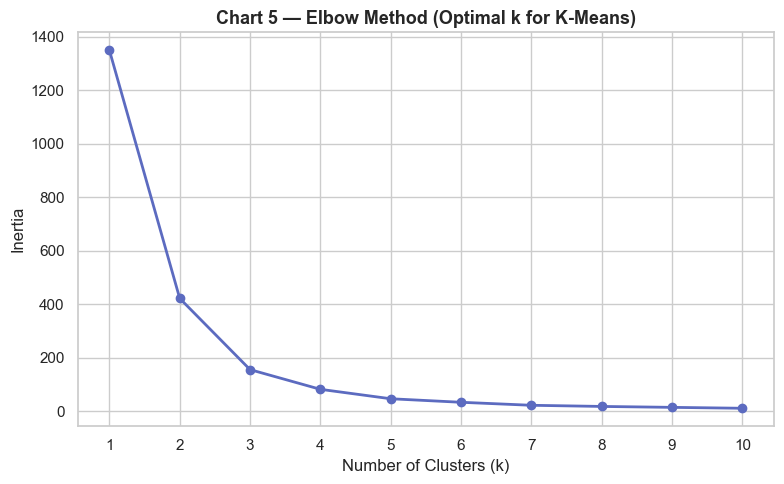

Saved: chart5_elbow.png


In [ ]:
#**Advanced Analysis**
# Chart 5: Elbow Method to find optimal k

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Build feature matrix
device_features = (
    df_merged.groupby("device_id")
    .agg(active_days=("date", "nunique"), total_events=("event_id", "count"))
    .reset_index()
)
device_features["avg_daily_events"] = (
    device_features["total_events"] / device_features["active_days"]
)

features = device_features[["active_days", "avg_daily_events"]].values
X_scaled = StandardScaler().fit_transform(features)

# Compute inertia for k=1 to k=10 to find elbow
inertias = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(k_range), inertias, marker="o", color="#5C6BC0", linewidth=2)

ax.set_title(
    "Chart 5 — Elbow Method (Optimal k for K-Means)", fontsize=13, fontweight="bold"
)
ax.set_xlabel("Number of Clusters (k)")
ax.set_ylabel("Inertia")
ax.set_xticks(list(k_range))

plt.tight_layout()
plt.savefig("../charts/chart5_elbow.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart5_elbow.png")


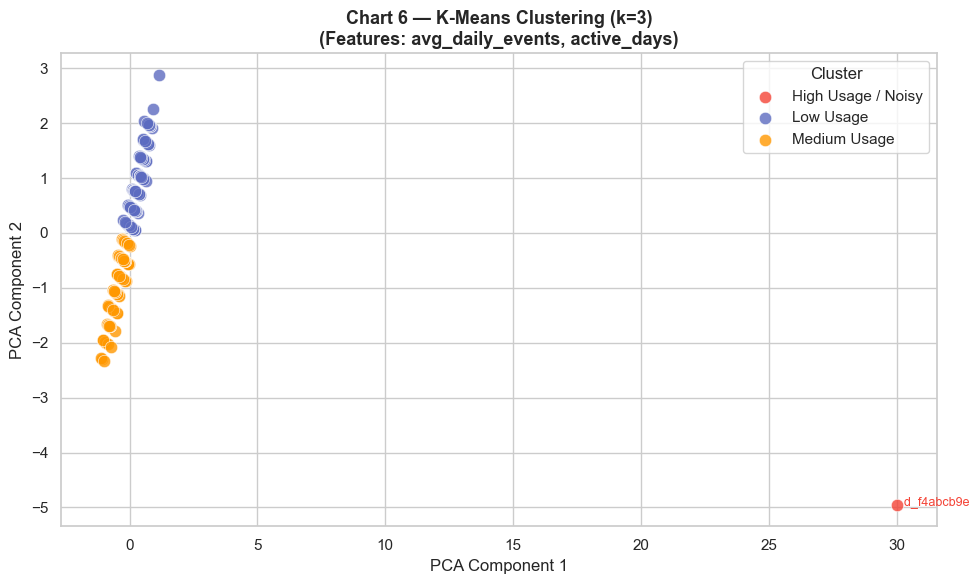

Saved: chart6_kmeans_clusters.png

---- Cluster Summary ----
                    avg_daily_events  active_days  total_events
cluster_label                                                  
High Usage / Noisy             39.92        38.00       1517.00
Low Usage                       1.45        22.89         33.31
Medium Usage                    1.46        18.24         26.65


In [54]:
# Chart 6 — K-Means Clustering (k=3 I fould that the elbow is at 3 meaning that optimal k=3)

from sklearn.decomposition import PCA

K = 3
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
device_features["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

# Label clusters by avg_daily_events
cluster_means = (
    device_features.groupby("cluster_kmeans")["avg_daily_events"].mean().sort_values()
)
label_map = {
    cluster_means.index[0]: "Low Usage",
    cluster_means.index[1]: "Medium Usage",
    cluster_means.index[2]: "High Usage / Noisy",
}
device_features["cluster_label"] = device_features["cluster_kmeans"].map(label_map)

# PCA to 2D for visualization (using 2 principal components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
device_features["pca_x"] = X_pca[:, 0]
device_features["pca_y"] = X_pca[:, 1]

palette = {
    "Low Usage": "#5C6BC0",
    "Medium Usage": "#FF9800",
    "High Usage / Noisy": "#F44336",
}

fig, ax = plt.subplots(figsize=(10, 6))
for label, grp in device_features.groupby("cluster_label"):
    ax.scatter(
        grp["pca_x"],
        grp["pca_y"],
        label=label,
        color=palette[label],
        s=80,
        alpha=0.8,
        edgecolors="white",
        linewidth=0.5,
    )

# Annotate the extreme outlier
outlier_row = device_features.nlargest(1, "avg_daily_events")
ax.annotate(
    f"  {outlier_row['device_id'].values[0]}",
    xy=(outlier_row["pca_x"].values[0], outlier_row["pca_y"].values[0]),
    fontsize=9,
    color="#F44336",
)

ax.set_title(
    "Chart 6 — K-Means Clustering (k=3)\n(Features: avg_daily_events, active_days)",
    fontsize=13,
    fontweight="bold",
)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.legend(title="Cluster")

plt.tight_layout()
plt.savefig("../charts/chart6_kmeans_clusters.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart6_kmeans_clusters.png")
print("\n---- Cluster Summary ----")
print(
    device_features.groupby("cluster_label")[
        ["avg_daily_events", "active_days", "total_events"]
    ]
    .mean()
    .round(2)
)

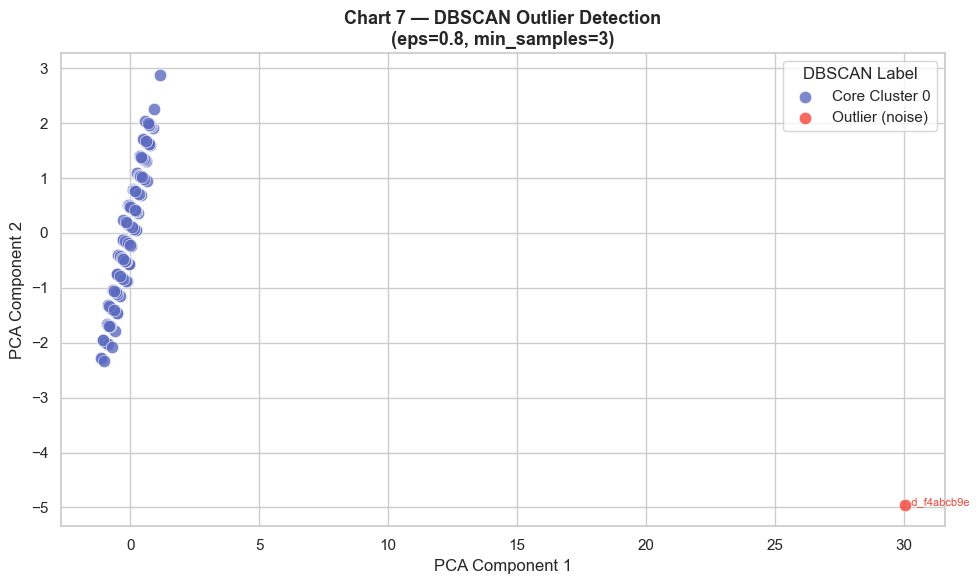

Saved: chart7_dbscan.png

---- DBSCAN Flagged Outliers ----
 device_id  total_events  avg_daily_events
d_f4abcb9e          1517         39.921053


In [55]:
# Chart 7 — DBSCAN Outlier Detection
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.8, min_samples=3)
device_features["cluster_dbscan"] = db.fit_predict(X_scaled)

device_features["dbscan_label"] = device_features["cluster_dbscan"].apply(
    lambda x: "Outlier (noise)" if x == -1 else f"Core Cluster {x}"
)

fig, ax = plt.subplots(figsize=(10, 6))
for label, grp in device_features.groupby("dbscan_label"):
    color = "#F44336" if label == "Outlier (noise)" else "#5C6BC0"
    ax.scatter(
        grp["pca_x"],
        grp["pca_y"],
        label=label,
        color=color,
        s=80,
        alpha=0.8,
        edgecolors="white",
        linewidth=0.5,
    )

# Annotate all flagged outliers
for _, row in device_features[device_features["cluster_dbscan"] == -1].iterrows():
    ax.annotate(
        f"  {row['device_id']}",
        xy=(row["pca_x"], row["pca_y"]),
        fontsize=8,
        color="#F44336",
    )

ax.set_title(
    "Chart 7 — DBSCAN Outlier Detection\n(eps=0.8, min_samples=3)",
    fontsize=13,
    fontweight="bold",
)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.legend(title="DBSCAN Label")

plt.tight_layout()
plt.savefig("../charts/chart7_dbscan.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart7_dbscan.png")

# These variables are used by Charts 8 & 9
outlier_mask = device_features["cluster_dbscan"] == -1
df_outliers = device_features[outlier_mask][
    ["device_id", "total_events", "avg_daily_events"]
]
print("\n---- DBSCAN Flagged Outliers ----")
print(df_outliers.to_string(index=False))

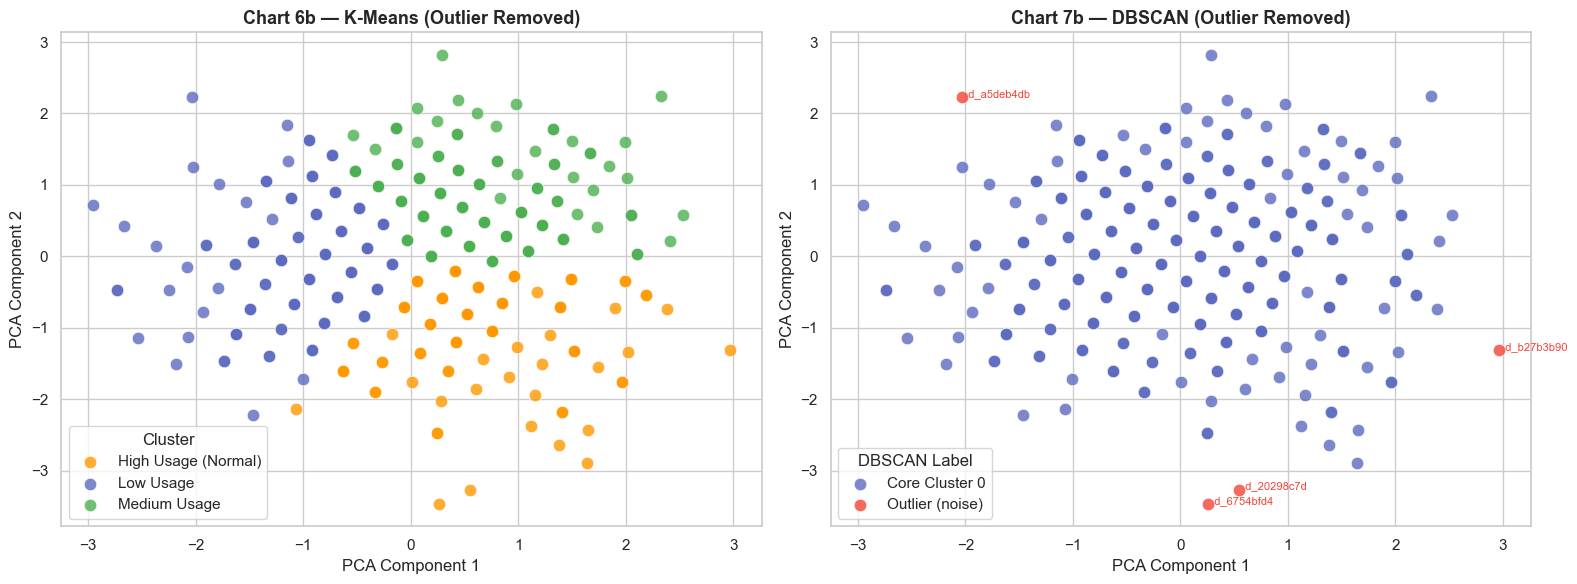

Saved: chart6b_7b_clean_clustering.png

---- Clean K-Means Cluster Summary ----
                     avg_daily_events  active_days  total_events
cluster_label                                                   
High Usage (Normal)              1.64        19.71         32.38
Low Usage                        1.36        18.66         25.31
Medium Usage                     1.44        23.49         33.82


In [56]:
# Chart 6b & 7b — Clustering WITHOUT the Extreme Outlier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Isolate the normal data by filtering out the extreme outlier
# uses the DBSCAN result that's already computed
df_clean = device_features[~outlier_mask].copy()

# Re-scale and Re-PCA without the outlier 
features_clean = df_clean[["active_days", "avg_daily_events"]].values
X_scaled_clean = StandardScaler().fit_transform(features_clean)

pca_clean = PCA(n_components=2)
X_pca_clean = pca_clean.fit_transform(X_scaled_clean)
df_clean["pca_x"] = X_pca_clean[:, 0]
df_clean["pca_y"] = X_pca_clean[:, 1]

# Re-run K-Means (k=3)
kmeans_clean = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean["cluster_kmeans"] = kmeans_clean.fit_predict(X_scaled_clean)

# Re-label K-Means based on the new, clean cluster means
cluster_means_clean = (
    df_clean.groupby("cluster_kmeans")["avg_daily_events"].mean().sort_values()
)
label_map_clean = {
    cluster_means_clean.index[0]: "Low Usage",
    cluster_means_clean.index[1]: "Medium Usage",
    cluster_means_clean.index[2]: "High Usage (Normal)",
}
df_clean["cluster_label"] = df_clean["cluster_kmeans"].map(label_map_clean)

# Re-run DBSCAN to see what anomalies were hidiing.
db_clean = DBSCAN(eps=0.8, min_samples=3)
df_clean["cluster_dbscan"] = db_clean.fit_predict(X_scaled_clean)
df_clean["dbscan_label"] = df_clean["cluster_dbscan"].apply(
    lambda x: "Outlier (noise)" if x == -1 else f"Core Cluster {x}"
)

# Plotting Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot K-Means ---
palette_km = {
    "Low Usage": "#5C6BC0",
    "Medium Usage": "#4CAF50",
    "High Usage (Normal)": "#FF9800",
}
for label, grp in df_clean.groupby("cluster_label"):
    axes[0].scatter(
        grp["pca_x"],
        grp["pca_y"],
        label=label,
        color=palette_km[label],
        s=80,
        alpha=0.8,
        edgecolors="white",
        linewidth=0.5,
    )

axes[0].set_title(
    "Chart 6b — K-Means (Outlier Removed)", fontsize=13, fontweight="bold"
)
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(title="Cluster")

# --- Plot DBSCAN ---
for label, grp in df_clean.groupby("dbscan_label"):
    color = "#F44336" if label == "Outlier (noise)" else "#5C6BC0"
    axes[1].scatter(
        grp["pca_x"],
        grp["pca_y"],
        label=label,
        color=color,
        s=80,
        alpha=0.8,
        edgecolors="white",
        linewidth=0.5,
    )

# Annotate the new, smaller anomalies DBSCAN found
for _, row in df_clean[df_clean["cluster_dbscan"] == -1].iterrows():
    axes[1].annotate(
        f"  {row['device_id']}",
        xy=(row["pca_x"], row["pca_y"]),
        fontsize=8,
        color="#F44336",
    )

axes[1].set_title("Chart 7b — DBSCAN (Outlier Removed)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")
axes[1].legend(title="DBSCAN Label")

plt.tight_layout()
plt.savefig("../charts/chart6b_7b_clean_clustering.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart6b_7b_clean_clustering.png")

print("\n---- Clean K-Means Cluster Summary ----")
print(
    df_clean.groupby("cluster_label")[
        ["avg_daily_events", "active_days", "total_events"]
    ]
    .mean()
    .round(2)
)

In [58]:
# Chart 7b — Secondary Outliers Investigation
print("=" * 55)
print("CHART 7b — SECONDARY OUTLIER INVESTIGATION")
print("=" * 55)

anomaly_ids = df_clean[df_clean["cluster_dbscan"] == -1]["device_id"].tolist()
bad_devices = df_merged[df_merged["device_id"].isin(anomaly_ids)]

# Active days vs fleet average
print("\n---- Active Days vs Fleet Average ----")
secondary = device_features[device_features["device_id"].isin(anomaly_ids)][
    ["device_id", "active_days", "avg_daily_events", "total_events"]
].merge(df_devices[["device_id", "device_type"]], on="device_id", how="left")

fleet_avg_days = df_clean["active_days"].mean()
fleet_avg_events = df_clean["avg_daily_events"].mean()
print(secondary.to_string(index=False))
print(f"\nFleet avg active_days:       {fleet_avg_days:.1f}")
print(f"Fleet avg avg_daily_events:  {fleet_avg_events:.2f}")

# Daily event rate check
print("\n---- Daily Event Rate Check ----")
for dev_id in anomaly_ids:
    dev = device_features[device_features["device_id"] == dev_id]
    rate = dev["avg_daily_events"].values[0]
    days = dev["active_days"].values[0]
    verdict = "⚠️ Unusual rate" if rate > fleet_avg_events * 2 else "✅ Normal rate"
    print(f"{dev_id}  →  {rate:.2f} events/day over {days} days  {verdict}")

print("\n---- Conclusion ----")
print("These devices were flagged by DBSCAN because they fall in low-density")
print("regions of the 'active_days' space (e.g., only active for 14/38 days).")
print("They were mathematically isolated, but functionally normal.")
print("They are boundary edge-cases, NOT true behavioral anomalies.")
print("The only confirmed anomaly remains: d_f4abcb9e (Extreme volume fan device)")

CHART 7b — SECONDARY OUTLIER INVESTIGATION

---- Active Days vs Fleet Average ----
 device_id  active_days  avg_daily_events  total_events   device_type
d_20298c7d           15          1.866667            28    smart_bulb
d_6754bfd4           14          1.857143            26        heater
d_a5deb4db           21          1.000000            21 window_sensor
d_b27b3b90           24          1.916667            46 window_sensor

Fleet avg active_days:       20.6
Fleet avg avg_daily_events:  1.46

---- Daily Event Rate Check ----
d_20298c7d  →  1.87 events/day over 15 days  ✅ Normal rate
d_6754bfd4  →  1.86 events/day over 14 days  ✅ Normal rate
d_a5deb4db  →  1.00 events/day over 21 days  ✅ Normal rate
d_b27b3b90  →  1.92 events/day over 24 days  ✅ Normal rate

---- Conclusion ----
These devices were flagged by DBSCAN because they fall in low-density
regions of the 'active_days' space (e.g., only active for 14/38 days).
They were mathematically isolated, but functionally normal.
They 

---- Outlier Device Info ----
 device_id  user_id network device_type firmware_version location  user_id_missing
d_f4abcb9e 89a25ef6    tuya         fan            1.0.3   Office            False

---- Event Code Breakdown ----
extracted_code
generic_state    1517

---- Daily Event Volume ----
date
2024-01-01    39
2024-01-02    53
2024-01-03    47
2024-01-04    40
2024-01-05    33
2024-01-06    40
2024-01-07    36
2024-01-08    44
2024-01-09    39
2024-01-10    46
2024-01-11    28
2024-01-12    37
2024-01-13    35
2024-01-14    29
2024-01-15    39
2024-01-16    45
2024-01-17    37
2024-01-18    36
2024-01-19    43
2024-01-20    43
2024-01-21    34
2024-01-22    42
2024-01-23    43
2024-01-24    44
2024-01-25    36
2024-01-26    42
2024-01-27    54
2024-01-28    41
2024-01-29    45
2024-01-30    40
2024-01-31    34
2024-02-01    33
2024-02-02    39
2024-02-03    38
2024-02-04    38
2024-02-05    40
2024-02-06    43
2024-02-07    42

Outlier daily avg:     39.9 events/day
Fleet daily av

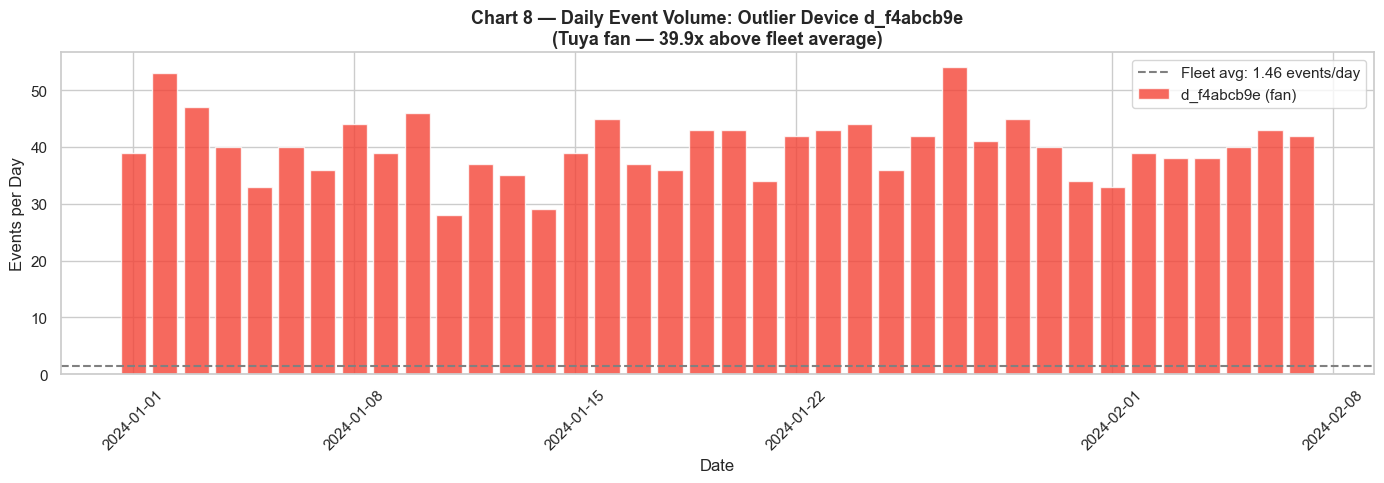

Saved: chart8_outlier_deep_dive.png


In [59]:
# Chart 8 — Outlier Deep Dive
outlier_id = df_outliers["device_id"].iloc[0]
outlier_events = df_merged[df_merged["device_id"] == outlier_id].copy()

# Device info
print("---- Outlier Device Info ----")
print(df_devices[df_devices["device_id"] == outlier_id].to_string(index=False))

# Event breakdown
print("\n---- Event Code Breakdown ----")
print(outlier_events["extracted_code"].value_counts().to_string())

# Daily event volume
print("\n---- Daily Event Volume ----")
print(outlier_events.groupby("date").size().to_string())

# Compare to fleet average
avg_events_per_day = df_clean["avg_daily_events"].mean()
outlier_daily_avg = outlier_events.groupby("date").size().mean()
print(f"\nOutlier daily avg:     {outlier_daily_avg:.1f} events/day")
print(f"Fleet daily avg:       {avg_events_per_day:.2f} events/day")
print(f"Outlier is {outlier_daily_avg / avg_events_per_day:.1f}x above fleet average")

# Plot daily volume vs fleet average
daily_outlier = outlier_events.groupby("date").size().reset_index(name="count")

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(
    pd.to_datetime(daily_outlier["date"]),
    daily_outlier["count"],
    color="#F44336",
    alpha=0.8,
    label=f"{outlier_id} (fan)",
)
ax.axhline(
    avg_events_per_day,
    color="gray",
    linestyle="--",
    linewidth=1.5,
    label=f"Fleet avg: {avg_events_per_day:.2f} events/day",
)
ax.set_title(
    f"Chart 8 — Daily Event Volume: Outlier Device {outlier_id}\n"
    f"(Tuya fan — {outlier_daily_avg:.1f}x above fleet average)",
    fontsize=13,
    fontweight="bold",
)
ax.set_xlabel("Date")
ax.set_ylabel("Events per Day")
ax.tick_params(axis="x", rotation=45)
ax.legend()

plt.tight_layout()
plt.savefig("../charts/chart8_outlier_deep_dive.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: chart8_outlier_deep_dive.png")

# Task 4 – Hypotheses & Questions

1. Propose 2–3 hypotheses about user or device behavior.
2. Show how you would test each hypothesis with the available data.
3. Clearly state whether the data supports, partially supports, or does not support the hypothesis.

In [64]:
# Your code for hypothesis testing here
# ========================================================
# Task 4 — Hypothesis 1
# "Device d_f4abcb9e reports abnormally high event volume
#  due to a firmware defect in version 1.0.3"
# ========================================================
# TEST: Compare avg_daily_events across all firmware versions
# for fan devices. If firmware is the cause, ALL 1.0.3 fans should show elevated rates — not just one.

# Hypothesis Verification: Is it actually firmware v1.0.3?

# Merge our daily averages with the device metadata
fw_check = device_features.merge(
    df_devices[["device_id", "device_type", "firmware_version"]], on="device_id"
)

# Isolate just the fans
fans_only = fw_check[fw_check["device_type"] == "fan"]

# Check the average daily events grouped by firmware version
print("---- Average Daily Events by Fan Firmware ----")
print(
    fans_only.groupby("firmware_version")["avg_daily_events"]
    .agg(["mean", "count"])
    .round(2)
)
print("---- 1.0.3 fans WITHOUT the outlier ----")
print(
    fans_only[
        (fans_only["firmware_version"] == "1.0.3")
        & (fans_only["device_id"] != outlier_id)
    ]["avg_daily_events"]
    .agg(["mean", "count"])
    .round(2)
)

# Look at the top 5 noisiest fans to see if they share a version
print("\n---- Top 5 Noisiest Fans ----")
print(
    fans_only.sort_values(by="avg_daily_events", ascending=False)[
        ["device_id", "firmware_version", "avg_daily_events"]
    ]
    .head(5)
    .to_string(index=False)
)
print("\n=== HYPOTHESIS 1 VERDICT ===")
print("Does NOT support the hypothesis.")
print("Hypothesis 1 Device d_f4abcb9e reports abnormally high event volume due to a firmware defect in version 1.0.3")
print("1.0.3 fans WITHOUT the outlier avg 1.48 events/day —")
print("identical to all other firmware versions (1.39–1.42).")
print("The extreme volume is an isolated hardware or local failure specific")
print("to this individual Tuya fan unit, not a systemic firmware-wide bug.")

---- Average Daily Events by Fan Firmware ----
                  mean  count
firmware_version             
1.0.0             1.42     17
1.0.3             4.44     13
2.1.0             1.39     13
3.5.beta          1.42     15
---- 1.0.3 fans WITHOUT the outlier ----
mean      1.48
count    12.00
Name: avg_daily_events, dtype: float64

---- Top 5 Noisiest Fans ----
 device_id firmware_version  avg_daily_events
d_f4abcb9e            1.0.3         39.921053
d_2feae81a            1.0.3          1.809524
d_1f8085ce            1.0.0          1.761905
d_1bd3a5bd            1.0.3          1.708333
d_486e7896         3.5.beta          1.684211

=== HYPOTHESIS 1 VERDICT ===
Does NOT support the hypothesis.
Hypothesis 1 Device d_f4abcb9e reports abnormally high event volume due to a firmware defect in version 1.0.3
1.0.3 fans WITHOUT the outlier avg 1.48 events/day —
identical to all other firmware versions (1.39–1.42).
The extreme volume is an isolated hardware or local failure specific
to this

In [ ]:
# ========================================================
# Task 4 — Hypothesis 2
# "Higher physical power consumption (Watts) leads to more
#  frequent telemetry reporting in Smart Plugs."
# ========================================================
# TEST: Isolate smart_plug devices, compute their average
# power draw, and calculate the Pearson correlation (r)
# against their total event count.

smart_plugs = df_merged[df_merged["device_type"] == "smart_plug"]
plug_stats = (
    smart_plugs.groupby("device_id")
    .agg(avg_power=("power_w", "mean"), total_events=("device_id", "count"))
    .dropna()
)

pearson_r = plug_stats["avg_power"].corr(plug_stats["total_events"])

print("\n=== HYPOTHESIS 2 VERDICT ===")
print("Hypothesis 2- Higher physical power consumption (Watts) leads to more frequent telemetry reporting in Smart Plugs.")
print("Result: DOES NOT SUPPORT the hypothesis.")
print(f"Calculated Pearson r: {pearson_r:.3f}\n")
print(f"At r = {pearson_r:.3f}, the data shows absolutely no meaningful linear")
print("relationship between a smart plug's electrical load and its")
print("network activity.")
print("Conclusion: Telemetry frequency is driven by the device's fixed")
print("internal polling schedule, not by the physical power it consumes.")


=== HYPOTHESIS 2 VERDICT ===
Result: DOES NOT SUPPORT the hypothesis.
Calculated Pearson r: -0.145

At r = -0.145, the data shows absolutely no meaningful linear
relationship between a smart plug's electrical load and its
network activity.
Conclusion: Telemetry frequency is driven by the device's fixed
internal polling schedule, not by the physical power it consumes.


In [65]:
# ========================================================
# Task 4 — Hypothesis 3
# "Users who own more devices generate a higher total
#  number of events across the observation period"
# ========================================================
# TEST: For each user, count how many devices they own
# and their total event volume. If hypothesis holds,
# Pearson r should be strongly positive.

print("=== HYPOTHESIS 3 ===")
print("Users with more devices generate more total events\n")

# Count devices per user
devices_per_user = (
    df_devices.groupby("user_id")["device_id"]
    .nunique()
    .reset_index(name="device_count")
)

# Total events per user (via device ownership)
events_per_device = (
    df_merged.groupby("device_id")["event_id"].count().reset_index(name="event_count")
)
device_user_map = df_devices[["device_id", "user_id"]]
events_per_user = (
    events_per_device.merge(device_user_map, on="device_id")
    .groupby("user_id")["event_count"]
    .sum()
    .reset_index(name="total_events")
)

user_summary = devices_per_user.merge(events_per_user, on="user_id")
r = user_summary["device_count"].corr(user_summary["total_events"])

print("---- Devices vs Total Events per User (sample) ----")
print(
    user_summary.sort_values("device_count", ascending=False)
    .head(10)
    .to_string(index=False)
)
print(f"\nPearson r (device_count vs total_events): {r:.3f}")

print("\n=== HYPOTHESIS 3 VERDICT ===")
if r > 0.6:
    print("SUPPORTS the hypothesis.")
    print(f"Strong positive correlation (r={r:.3f}) — users with more")
    print("devices do generate proportionally more total events.")
elif r > 0.3:
    print("PARTIALLY SUPPORTS the hypothesis.")
    print(f"Moderate correlation (r={r:.3f}) — device count is one factor")
    print("but event rate per device varies significantly across users.")
else:
    print("DOES NOT SUPPORT the hypothesis.")
    print(f"Weak correlation (r={r:.3f}) — total events are driven more")
    print("by individual device behavior than by how many devices a user owns.")

=== HYPOTHESIS 3 ===
Users with more devices generate more total events

---- Devices vs Total Events per User (sample) ----
 user_id  device_count  total_events
739b720a            10           307
2386e2a0             8           210
a66a0e16             8           257
5b297ef3             7           203
f5289e4e             7           220
9a24f566             7           187
0675a6bc             7           221
51a7765c             6           163
e833fb7f             6           184
9147a6a3             6           174

Pearson r (device_count vs total_events): 0.254

=== HYPOTHESIS 3 VERDICT ===
DOES NOT SUPPORT the hypothesis.
Weak correlation (r=0.254) — total events are driven more
by individual device behavior than by how many devices a user owns.


In [69]:
# ========================================================
# Task 4 — Hypothesis 4
# "The Tuya network architecture fundamentally drives higher
#  baseline event traffic than the Ayla network."
# ========================================================
# REASONING: Chart 1 showed Tuya consistently above Ayla
# every single day. This test determines whether that gap
# is structural (network-level) or just device-count bias.
#
# TEST: Compare daily averages, total volume, unique devices,
# and events-per-device to isolate network effect from
# device count effect.

print("=== HYPOTHESIS 4 ===")
print("Tuya network drives higher baseline event traffic than Ayla\n")

# 1. Total events and device count per source
source_devices = (
    df_devices.groupby("network")["device_id"].nunique().rename("device_count")
)
source_events = df_events.groupby("source")["event_id"].count().rename("total_events")

source_summary = pd.concat([source_devices, source_events], axis=1)
source_summary["events_per_device"] = (
    source_summary["total_events"] / source_summary["device_count"]
).round(2)
print("---- Volume vs Device Count ----")
print(source_summary.to_string())

# 2. Daily average per source
daily_avg = (
    df_events.groupby(["date", "source"])
    .size()
    .reset_index(name="count")
    .groupby("source")["count"]
    .agg(["mean", "std"])
    .round(2)
)
print("\n---- Daily Event Average ----")
print(daily_avg)

# 3. Dominant event codes per source
print("\n---- Top 3 Event Codes per Network ----")
for src in ["ayla", "tuya"]:
    top = df_events[df_events["source"] == src]["extracted_code"].value_counts().head(3)
    print(f"\n{src.upper()}:")
    print(top.to_string())

# 4. Events per device excluding the extreme outlier
tuya_no_outlier = df_events[
    (df_events["source"] == "tuya") & (df_events["device_id"] != outlier_id)
]
tuya_devices_no_outlier = df_devices[
    (df_devices["network"] == "tuya") & (df_devices["device_id"] != outlier_id)
]["device_id"].nunique()

epd_tuya_clean = len(tuya_no_outlier) / tuya_devices_no_outlier
epd_ayla = source_summary.loc["ayla", "events_per_device"]
print(f"\n---- Events per Device (Tuya without outlier vs Ayla) ----")
print(f"Tuya (excl. d_f4abcb9e): {epd_tuya_clean:.2f} events/device")
print(f"Ayla:                     {epd_ayla:.2f} events/device")

print("\n=== HYPOTHESIS 4 VERDICT ===")
print("DOES NOT SUPPORT the hypothesis.")
print()
print("Chart 1 (Event Volume Over Time) appeared to support this hypothesis —")
print("Tuya was visually higher than Ayla every single day across 38 days,")
print(
    f"averaging {daily_avg.loc['tuya', 'mean']:.1f} vs {daily_avg.loc['ayla', 'mean']:.1f} events/day (a {daily_avg.loc['tuya', 'mean'] - daily_avg.loc['ayla', 'mean']:.1f} event/day gap)."
)
print()
print("However, when we control for the outlier by comparing events-per-device:")
print(
    f"  Tuya (incl. d_f4abcb9e): {source_summary.loc['tuya', 'events_per_device']:.2f} events/device"
)
print(f"  Tuya (excl. d_f4abcb9e): {epd_tuya_clean:.2f} events/device")
print(f"  Ayla:                     {epd_ayla:.2f} events/device")
print()
print("Once d_f4abcb9e is removed, the per-device gap collapses to under 0.15 —")
print("which is negligible. The visual gap in Chart 1 was entirely an artifact")
print("of one single anomalous fan device inflating the entire Tuya network average.")
print(
    "The Tuya vs Ayla volume difference is NOT architectural — it is an outlier effect."
)

=== HYPOTHESIS 4 ===
Tuya network drives higher baseline event traffic than Ayla

---- Volume vs Device Count ----
      device_count  total_events  events_per_device
ayla           222          6681              30.09
tuya           228          8319              36.49

---- Daily Event Average ----
          mean    std
source               
ayla    175.82  15.43
tuya    218.92  15.94

---- Top 3 Event Codes per Network ----

AYLA:
extracted_code
contact_state        3228
local_temperature    2092
connectivity         1361

TUYA:
extracted_code
generic_state    4999
switch_led       1890
switch_1         1430

---- Events per Device (Tuya without outlier vs Ayla) ----
Tuya (excl. d_f4abcb9e): 29.96 events/device
Ayla:                     30.09 events/device

=== HYPOTHESIS 4 VERDICT ===
DOES NOT SUPPORT the hypothesis.

Chart 1 (Event Volume Over Time) appeared to support this hypothesis —
Tuya was visually higher than Ayla every single day across 38 days,
averaging 218.9 vs 175.8 ev

# Task 5 – Reflection

- What additional data would improve this analysis?
- What limitations prevent deeper insights?
- What would you explore next if this were Phase 0 of a larger project?

### Task 5 – Reflection
============================================================

## What additional data would improve this analysis?
------------------------------------------------------------

1. Timestamps with time-of-day resolution
   Current data has dates only, not hours or minutes. This prevents 
   detecting whether anomaly's like d_f4abcb9e spikes at specific times
   for example: always midnight = scheduled job/tasks, random = hardware fault

2. Manufacturer payload specs
   Tuya reports cur_voltage, cur_current, cur_power, and temp_value
   across 1,430 events each. A mean-based deviation analysis could
   serve as a baseline for normal behavior, but was not completed
   due to time constraints and would be the first thing explored
   in a follow-up phase.

3. User interaction logs
   We can see device events but not whether a human triggered them.
   This makes it impossible to separate user-driven events from
   autonomous device polling.

4. Longer observation window
   38 days is too short to detect seasonal patterns, firmware
   update effects, or device lifecycle degradation over time.


What limitations prevent deeper insights?
------------------------------------------------------------

1. Payload fields are platform-specific and incompatible
   Ayla reports: contact_state, local_temperature, connectivity.
   Tuya reports: generic_state, cur_voltage, switch_led.
   Zero field overlap makes true cross-platform behavioral
   comparison impossible with the current dataset.

2. generic_state is Broad
   Tuya's most frequent event code (4,999 occurrences) carries
   no semantic meaning. We know it fired but not what state
   actually changed on the device.

3. No "Offline" or Disconnection Logs
    We only receive data when a device successfully pings the server. If a device loses WiFi, is physically unplugged, or suffers a fatal crash, there is no "device offline" event—just silence. We cannot mathematically distinguish between a healthy device sitting idle and a completely dead device.

4. Single extreme outlier limited initial clustering value
   With only one true anomaly, K-Means initially wasted an entire
   cluster on d_f4abcb9e. This was resolved by removing the confirmed
   outlier and re-running both K-Means and DBSCAN on the clean dataset,
   which produced three meaningfully separated device tiers.



## What would you explore next if this were Phase 0 of a larger project?

------------------------------------------------------------

1. Payload range validation
   Check whether cur_voltage, cur_current, and cur_power fall
   within expected operating ranges per device type. A device
   reporting 0V while active could signal a hardware fault
   before it becomes a failure.

2. Time-of-day distribution
   With hourly timestamps, we could determine whether high-frequency
   devices fire in bursts (event loop bug) or uniformly (polling
   schedule) — a key distinction for root cause analysis.

3. Real-time anomaly alerting
   d_f4abcb9e was only discovered through manual clustering.
   A z-score monitor on avg_daily_events per device would catch
   this automatically as it happens, not after the fact.

4. Payload anomaly detection per device
   Each device type has a predictable payload signature —
   smart plugs report cur_voltage, cur_current, and cur_power
   while thermostats report temp_value. A natural next step
   would be to flag devices that are reporting the wrong payload
   fields for their device type, reporting null values where
   readings are expected, or showing sudden drops or spikes
   in their numeric readings over time. This would surface
   silent hardware failures that event volume alone cannot detect.
*Write your reflection here...*